In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Toxicity_analysis_neural

/content/drive/.shortcut-targets-by-id/1kT85QsRLsdT1SfyA6FtA2O_u0c7SU7Lv/Toxicity_analysis_neural


In [3]:
!pip install tensorflow tensorflow pandas matplotlib scikit-learn

In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [5]:
df = pd.read_csv('train.csv')

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.33.0
aiohappyeyeballs                 2.4.0
aiohttp                          3.10.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.14
albumentations                   1.4.14
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.3
astropy-iers-data                0.2024.8.27.10.28.29
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            24.2.0
audioread             

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
X

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."
...,...
159566,""":::::And for the second time of asking, when ..."
159567,You should be ashamed of yourself \n\nThat is ...
159568,"Spitzer \n\nUmm, theres no actual article for ..."
159569,And it looks like it was actually you who put ...


In [10]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [11]:
MAX_FEATURES = 200000 # number of words in the vocab

In [12]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [13]:
vectorizer.adapt(X.values)

In [14]:
vectorized_text = vectorizer(X.values)

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [17]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [19]:
train_generator = train.as_numpy_iterator()

In [20]:
train_generator.next()

(array([[  451, 21816,     4, ...,     0,     0,     0],
        [   40,    76,    88, ...,     0,     0,     0],
        [   39,     7,   264, ...,     0,     0,     0],
        ...,
        [   24,  1139,    18, ...,     0,     0,     0],
        [   46,    33,    15, ...,     0,     0,     0],
        [ 3301,   101,   742, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [27]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [26]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 715s 102ms/step - loss: 0.0518 - val_loss: 0.0427
Epoch 2/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 742s 102ms/step - loss: 0.0450 - val_loss: 0.0400
Epoch 3/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 728s 104ms/step - loss: 0.0382 - val_loss: 0.0340
Epoch 4/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 742s 104ms/step - loss: 0.0351 - val_loss: 0.0315
Epoch 5/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 728s 102ms/step - loss: 0.0310 - val_loss: 0.0274
Epoch 6/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 741s 102ms/step - loss: 0.0284 - val_loss: 0.0264
Epoch 7/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 719s 103ms/step - loss: 0.0251 - val_loss: 0.0226
Epoch 8/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 746s 104ms/step - loss: 0.0225 - val_loss: 0.0207
Epoch 9/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 718s 103ms/step - loss: 0.0206 - val_loss: 0.0183
Epoch 10/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 739s 103ms/step - loss: 0.0183 - val_loss: 0.0169
Epoch 11/15
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 715s 102ms/step - loss: 0.0171 - val

1994/1994 ━━━━━━━━━━━━━━━━━━━━ 97s 48ms/step


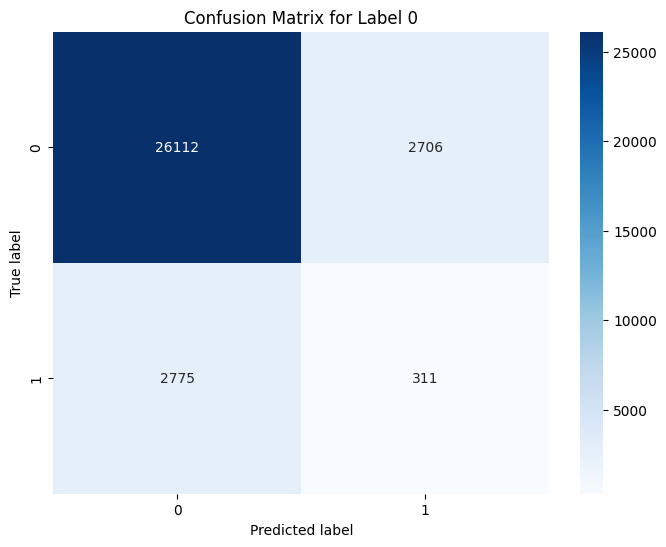

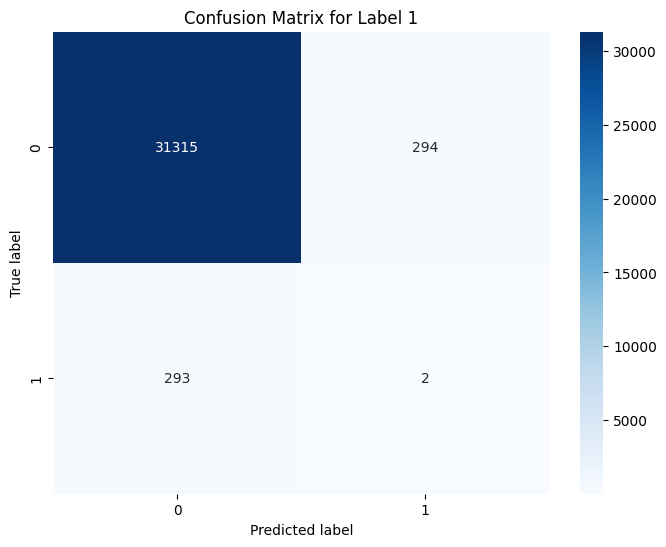

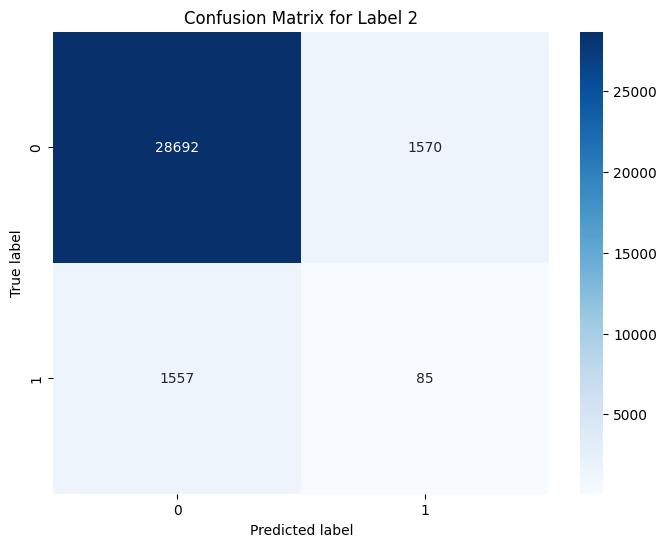

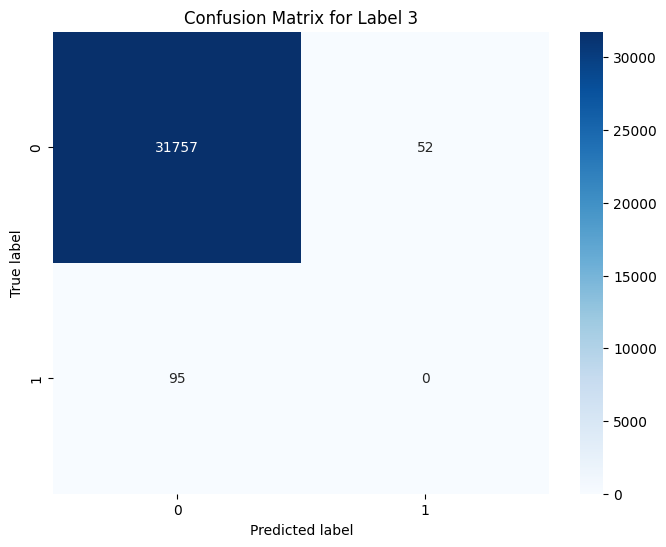

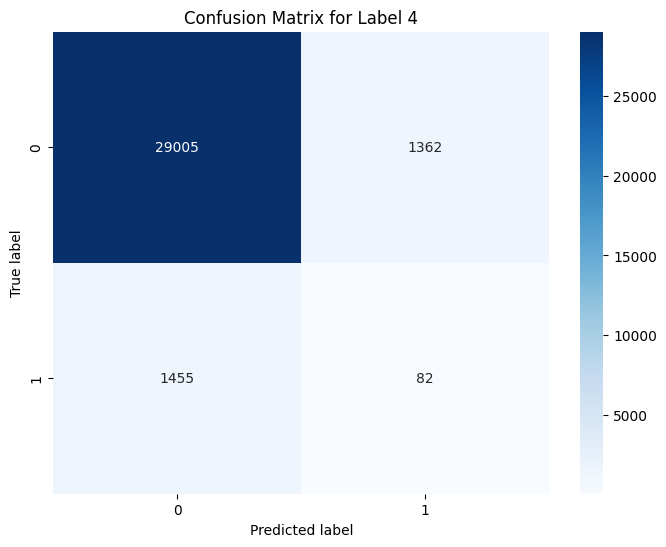

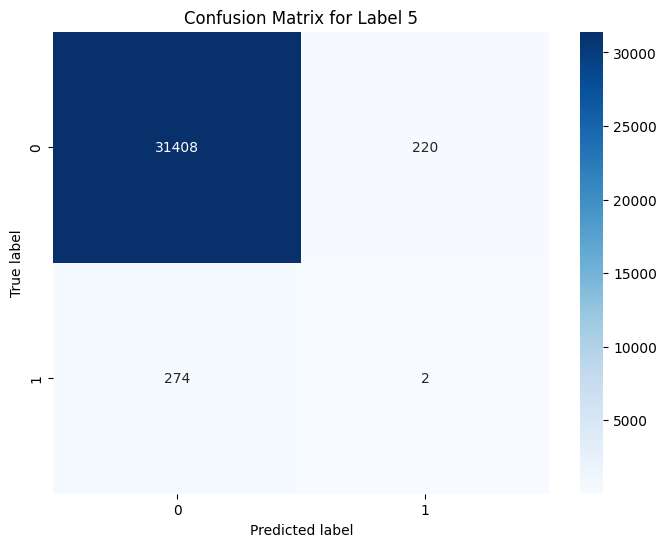

Accuracy: 0.8117
Precision: 0.0378
Recall: 0.0367
F1 Score: 0.0372


KeyError: 'accuracy'

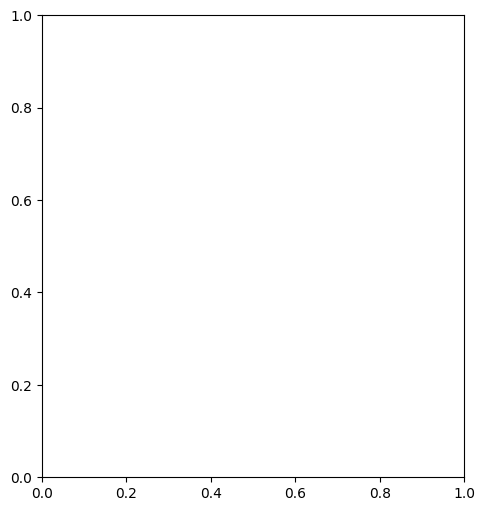

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


y_val_true = np.concatenate([y for x, y in val], axis=0)  # True labels from validation data
y_val_pred_prob = model.predict(val)  # Predicted probabilities
y_val_pred = (y_val_pred_prob > 0.5).astype("int32")  # Convert probabilities to class labels


conf_matrix = multilabel_confusion_matrix(y_val_true, y_val_pred)

# Plot the confusion matrix for each label
for i, matrix in enumerate(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for Label {i}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


accuracy = accuracy_score(y_val_true, y_val_pred)  # For multilabel, this calculates exact match ratio
precision = precision_score(y_val_true, y_val_pred, average='macro')  # Average precision over labels
recall = recall_score(y_val_true, y_val_pred, average='macro')  # Average recall over labels
f1 = f1_score(y_val_true, y_val_pred, average='macro')  # Average F1 score over labels

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.tight_layout()
plt.show()


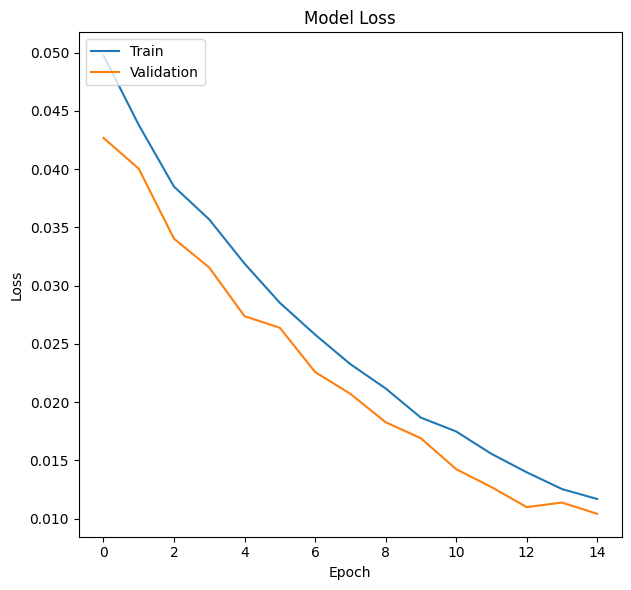

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# Step 5: Plot Accuracy and Loss over Epochs (from model history)
plt.figure(figsize=(12, 6))

# # First subplot for Accuracy
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# Second subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [25]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

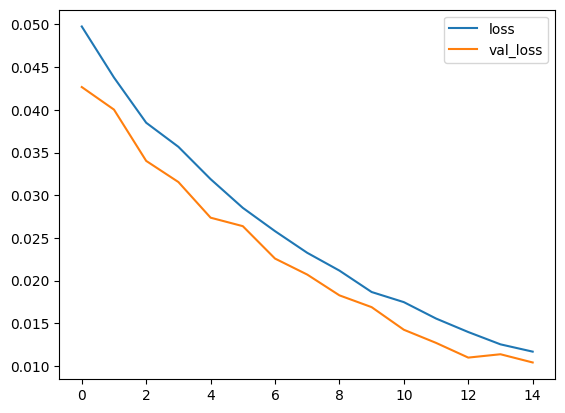

In [26]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [28]:
model.save('toxicity_new.h5')

Make Predictions

Input text should be passed throught he vectorizer

In [32]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [33]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [34]:
model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


array([[0.9999591 , 0.77738446, 0.9985103 , 0.24133529, 0.96469027,
        0.35232434]], dtype=float32)

In [35]:
batch = test.as_numpy_iterator().next()

In [36]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [37]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [38]:
(model.predict(batch_X)  > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [39]:
res = model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [40]:
res = model.predict(batch_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [41]:
res.flatten()

array([3.90691048e-06, 2.07941712e-27, 1.20764510e-09, 9.27260616e-18,
       2.12700649e-10, 3.35548578e-14, 1.77741993e-06, 7.27541884e-29,
       1.02396547e-09, 3.99303952e-21, 2.58240963e-11, 5.29893687e-17,
       1.15628856e-20, 0.00000000e+00, 9.23655432e-27, 0.00000000e+00,
       5.07152783e-37, 0.00000000e+00, 2.13866009e-19, 0.00000000e+00,
       6.66750352e-26, 0.00000000e+00, 3.78427470e-34, 0.00000000e+00,
       6.40334934e-02, 1.70743340e-06, 1.55987656e-02, 9.01975960e-04,
       1.81033369e-02, 1.52701384e-03, 9.98970747e-01, 5.41427210e-02,
       9.90533113e-01, 6.20908077e-06, 2.94432133e-01, 9.26623034e-05,
       7.14488211e-04, 5.56895708e-17, 3.56697228e-06, 4.05786030e-11,
       3.40087149e-06, 4.49276039e-09, 5.93025959e-07, 1.34157160e-31,
       1.17290955e-10, 1.37134085e-21, 3.36269077e-12, 9.92250956e-18,
       2.97645424e-22, 0.00000000e+00, 7.06024492e-29, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.14863033e-17, 0.00000000e+00,
      

Evaluate model: Binary classification: since having mulitple binary outputs we can use binary classification metrics like precision and recall.


In [42]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [44]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

In [45]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9652199745178223, Recall:0.9141328930854797, Accuracy:0.5115346312522888


Test and gradio

In [46]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing

In [28]:
import tensorflow as tf
import gradio as gr

ModuleNotFoundError: No module named 'gradio'

In [48]:
model.save('toxicity_new.h5')

In [49]:
model = tf.keras.models.load_model('toxicity_new.h5')

In [50]:
input_str = vectorizer('I will kill you')

In [51]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


In [52]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [53]:
res

array([[0.9888377 , 0.04968417, 0.0345584 , 0.8260033 , 0.07610614,
        0.00503684]], dtype=float32)

In [54]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [55]:
import gradio as gr

def score_comment(comment):
    # Placeholder function logic here
    return "Scored comment"

interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
    outputs='text'
)

# Launch the interface
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e03ad95eb651accf0d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [56]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [59]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx] > 0.5)

    return text

import gradio as gr

interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text')

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4c00cbadb1ae427146.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
